In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
import os
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
import re
from tqdm import tqdm
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import Counter

from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

import plotly.graph_objects as go
import plotly.express as px

# from data.CityStreet.projection_code.camera_proj_Zhang import * # Projection code for image2world
from src.camera_proj_modified import *  # Projection code for image2world

In [2]:
# display list of images with image channel handling
def display_image(*imgs):
    n = len(imgs)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(imgs[i].shape) == 2:  # grayscale
            plt.imshow(imgs[i], cmap='gray')
        else:  # color
            plt.imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

import math
import matplotlib.pyplot as plt
import cv2 as cv

def draw_predictions_multi(
    images,              # list of images
    predictions_list,    # list of prediction lists, same length as images
    category=None,       # optional filter (string)
    titles=None,         # list of titles, same length as images
    cols=2,              # number of columns in the grid
    figsize_per_image=(6, 6)
):
    n = len(images)
    assert len(predictions_list) == n, "predictions_list must match images length"

    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]

    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols,
                             figsize=(figsize_per_image[0]*cols,
                                      figsize_per_image[1]*rows))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for ax, img, preds, title in zip(axes, images, predictions_list, titles):
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=12)
        ax.axis('off')

        for pred in preds:
            # filter category
            if category is not None and pred.category.name != category:
                continue

            x1, y1, x2, y2 = map(int, pred.bbox.to_xyxy())
            ax.add_patch(plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor='red', linewidth=1
            ))
            ax.text(
                x1, y1 - 5,
                f'{pred.category.name}: {pred.score.value:.2f}',
                color='red', fontsize=6, weight='bold'
            )

    # turn off any unused axes
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



In [3]:
def load_CityStreet_images(num_images, image_frames='data/CityStreet/image_frames', start_frame=636):
    camera_names = ['camera1', 'camera3', 'camera4']

    images = pd.DataFrame(columns=['frame'] + camera_names)
    for idx in tqdm(range(num_images)):
        frame = 2 * idx + start_frame  # camera captures every other frame
        row = {'frame': frame}
        for camera in camera_names:
            image_path = os.path.join(image_frames, camera, f'frame_{frame:04d}.jpg')
            row[camera] = cv.imread(image_path)

        images = pd.concat([images, pd.DataFrame([row])], ignore_index=True)

    return images

image_df = load_CityStreet_images(5)


100%|██████████| 5/5 [00:00<00:00, 24.22it/s]


In [4]:
def create_camera_animation(image_df, camera='camera1', save_path='camera_animation.mp4', fps=10):
    """
    Create a simple frame-by-frame animation from camera frames.
    
    Parameters:
    - image_df: DataFrame with camera column containing frames
    - camera: Column name for the camera (default: 'camera1')
    - save_path: Path to save animation (mp4 or gif)
    - fps: Frames per second for animation
    """
    frames = image_df[camera]
    num_frames = len(frames)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Initialize with first frame
    im = ax.imshow(frames[0])
    title = ax.set_title(f'Frame 1/{num_frames}', fontsize=14, fontweight='bold')
    
    def update(frame_idx):
        im.set_array(frames[frame_idx])
        title.set_text(f'Frame {frame_idx + 1}/{num_frames}')
        return [im, title]
    
    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        interval=1000/fps,
        blit=True,
        repeat=True
    )
    
    # Save animation
    if save_path.endswith('.gif'):
        anim.save(save_path, writer='pillow', fps=fps)
    else:
        anim.save(save_path, writer='ffmpeg', fps=fps, dpi=100)
    
    plt.close()
    print(f'Animation saved to {save_path}')
    
    return anim


# Usage:
anim = create_camera_animation(image_df, camera='camera1', fps=1)

# For inline viewing in Jupyter:
from IPython.display import HTML
HTML(anim.to_html5_video())

Animation saved to camera_animation.mp4


In [5]:
# Load a model (will auto-download on first run)
model_path = "yolo-models/yolo11n.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [7]:
def predict(
    image,
    detection_model,
    slice_height=1024,
    slice_width=1024,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
):
    objects = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    ).object_prediction_list

    bboxes = [o.bbox.to_xyxy() for o in objects]
    scores = [o.score.value for o in objects]
    categories = [o.category.name for o in objects]

    return bboxes, scores, categories


In [8]:
bboxes, scores, categories = predict(image_df.loc[0, 'camera1'], detection_model)

Performing prediction on 8 slices.


## Tracker Archive
---

In [ ]:
tracker = DeepSort(
    max_age=30,              # Increased: Keep tracks alive longer (default: 30-70)
                                # If object disappears for N frames, track is deleted
                                # For low FPS, increase this (e.g., 50-100)
    
    n_init=1,                # Decreased: Confirm tracks faster (default: 3)
                                # Number of consecutive detections before track is confirmed
                                # Lower = faster confirmation (but more false positives)
    
    max_iou_distance=0.9,    # Increased: Allow larger movement between frames (default: 0.7)
                                # Higher = more tolerant to position changes
                                # For fast motion, try 0.8-0.9
    
    max_cosine_distance=0.3, # Tuned: Appearance similarity threshold (default: 0.2)
                                # Higher = more tolerant to appearance changes
                                # For fast motion blur, increase to 0.4-0.5
    
    nn_budget=100,           # Feature memory: Keep more past appearances
    
    embedder="mobilenet",    # Feature extractor (options: mobilenet, torchreid, clip)
)

In [41]:
# Master dict: track_id -> { "categories": [], "bboxes": [None, ..., bbox] }
tracks_dict = {}
num_frames = len(image_df['camera1'])

for frame_idx, frame in enumerate(image_df['camera1']):
    # YOLO detection
    boxes = get_sliced_prediction(
        image=frame,
        detection_model=detection_model,
        slice_height=1024,
        slice_width=1024,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
    ).object_prediction_list
    
    # Convert YOLO detections to DeepSort format
    detections = []
    cls_id_to_name = {}  # Map class_id -> class_name
    
    for box in boxes:
        x1, y1, x2, y2 = box.bbox.to_xyxy()
        bbox_xywh = [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]
        cls_id = int(box.category.id)
        
        detections.append((bbox_xywh, float(box.score.value), cls_id))
        cls_id_to_name[cls_id] = box.category.name
    
    # DeepSort tracking step
    tracks = tracker.update_tracks(detections, frame=frame)
    
    # For each confirmed track
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        l, t, r, b = track.to_ltrb()
        bbox_ltrb = [int(l), int(t), int(r), int(b)]
        
        # Get category from track's detection class
        category = cls_id_to_name.get(track.det_class) if hasattr(track, 'det_class') else None
        
        # Create entry if new track
        if track_id not in tracks_dict:
            tracks_dict[track_id] = {
                "categories": [],
                "bboxes": [None] * num_frames,
            }
        
        # Collect category prediction
        if category:
            tracks_dict[track_id]["categories"].append(category)
        
        tracks_dict[track_id]["bboxes"][frame_idx] = bbox_ltrb

# Convert to DataFrame with majority vote
track_df = pd.DataFrame([
    {
        "track_id": track_id,
        "category": Counter(data["categories"]).most_common(1)[0][0] if data["categories"] else None,
        "confidence": Counter(data["categories"]).most_common(1)[0][1] / len(data["categories"]) if data["categories"] else 0.0,
        "bbox": data["bboxes"],
    }
    for track_id, data in tracks_dict.items()
])

Performing prediction on 8 slices.
Performing prediction on 8 slices.
Performing prediction on 8 slices.
Performing prediction on 8 slices.
Performing prediction on 8 slices.


In [42]:
track_df.head()

,track_id,category,confidence,bbox
0,1,person,1.0,"[None, [2067, 1135, 2148, 1273], [2065, 1134, ..."
1,2,person,1.0,"[None, [2157, 885, 2222, 984], [2158, 884, 222..."
2,3,person,1.0,"[None, [762, 533, 792, 616], [765, 547, 790, 6..."
3,5,person,1.0,"[None, [2000, 916, 2065, 1033], [1996, 911, 20..."
4,6,person,1.0,"[None, [540, 1105, 620, 1268], [543, 1102, 627..."


In [ ]:
# Generate random colors for each track
def get_track_color(track_id, seed=42):
    np.random.seed(int(track_id) + seed)
    return np.random.rand(3,)

def visualize_tracks(image_df, track_df, save_path='tracking_animation.mp4', fps=10, trail_length=30):
    """
    Create frame-by-frame animation of tracked objects with trails.
    
    Parameters:
    - image_df: DataFrame with 'camera1' column containing frames
    - track_df: DataFrame with columns ['track_id', 'category', 'bbox', 'confidence']
    - save_path: Path to save animation (mp4 or gif)
    - fps: Frames per second for animation
    - trail_length: Number of previous frames to show as trail (0 to disable)
    """
    num_frames = len(image_df['camera1'])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    def update(frame_idx):
        ax.clear()
        
        # Display current frame
        frame = image_df['camera1'][frame_idx]
        ax.imshow(frame)
        ax.set_title(f'Frame {frame_idx + 1}/{num_frames}', fontsize=14, fontweight='bold')
        ax.axis('off')
        
        # Draw each track
        for _, row in track_df.iterrows():
            track_id = row['track_id']
            category = row['category']
            bboxes = row['bbox']
            confidence = row.get('confidence', 1.0)
            
            # Get current bbox
            current_bbox = bboxes[frame_idx]
            if current_bbox is None:
                continue
            
            color = get_track_color(track_id)
            x1, y1, x2, y2 = current_bbox
            width = x2 - x1
            height = y2 - y1
            
            # Draw bounding box
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2.5,
                edgecolor=color,
                facecolor='none',
                linestyle='-'
            )
            ax.add_patch(rect)
            
            # Draw label with background
            label = f'ID:{track_id} {category} ({confidence:.0%})'
            text_y = y1 - 5 if y1 > 20 else y2 + 15
            ax.text(
                x1, text_y, label,
                color='white',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8, edgecolor='none')
            )
            
            # Draw trail (path history)
            if trail_length > 0:
                trail_start = max(0, frame_idx - trail_length)
                centers = []
                
                for past_idx in range(trail_start, frame_idx):
                    past_bbox = bboxes[past_idx]
                    if past_bbox is not None:
                        # Calculate center point
                        cx = (past_bbox[0] + past_bbox[2]) / 2
                        cy = (past_bbox[1] + past_bbox[3]) / 2
                        centers.append((cx, cy))
                
                # Draw trail line with fading effect
                if len(centers) > 1:
                    centers = np.array(centers)
                    for i in range(len(centers) - 1):
                        alpha = (i + 1) / len(centers)  # Fade from old to new
                        ax.plot(
                            centers[i:i+2, 0], centers[i:i+2, 1],
                            color=color,
                            linewidth=2,
                            alpha=alpha * 0.6
                        )
                
                # Draw current center point
                if current_bbox:
                    cx = (x1 + x2) / 2
                    cy = (y1 + y2) / 2
                    ax.plot(cx, cy, 'o', color=color, markersize=6, markeredgecolor='white', markeredgewidth=1.5)
        
        return ax,
    
    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        interval=1000/fps,
        blit=False,
        repeat=True
    )
    
    # Save animation
    if save_path.endswith('.gif'):
        anim.save(save_path, writer='pillow', fps=fps)
    else:
        anim.save(save_path, writer='ffmpeg', fps=fps, dpi=100)
    
    plt.close()
    print(f'Animation saved to {save_path}')
    
    return anim

# Usage:
anim = visualize_tracks(
    image_df[track_df['category']=='person'],
    track_df[track_df['category']=='person'], 
    save_path='output.mp4', 
    fps=1, 
    trail_length=30)

from IPython.display import HTML
HTML(anim.to_html5_video())

NameError: name 'track_df' is not defined

## Archived
---

In [6]:
img1 = image_df['camera1'][1]
img2 = image_df['camera3'][1]

In [7]:
view1_result = get_sliced_prediction(
    image=img1,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view1_pred = view1_result.object_prediction_list

view2_result = get_sliced_prediction(
    image=img2,
    detection_model=detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
view2_pred = view2_result.object_prediction_list

Performing prediction on 28 slices.
Performing prediction on 28 slices.


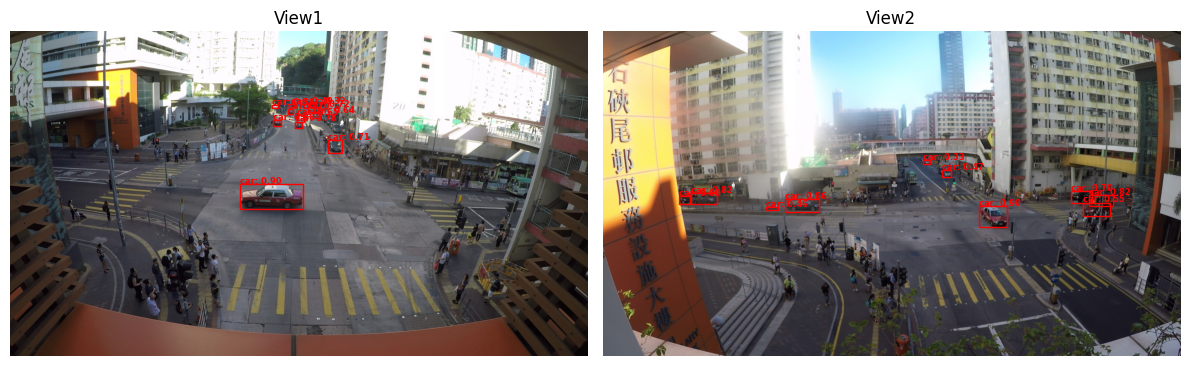

In [8]:
draw_predictions_multi(
    images=[img1, img2],
    predictions_list=[view1_pred, view2_pred],
    category='car',
    titles = ['View1', 'View2']
)

In [9]:
img1.shape

(1520, 2704, 3)

In [10]:
view1_pred.sort(key=lambda pred: pred.score.value, reverse=True)
view2_pred.sort(key=lambda pred: pred.score.value, reverse=True)

In [ ]:
bbox1 = view1_pred[0].bbox.to_xyxy()
x1C = (bbox1[0] + bbox1[2]) / 2
y1C = (bbox1[1] + bbox1[3]) / 2
bbox2 = view2_pred[0].bbox.to_xyxy()
x2C = (bbox2[0] + bbox2[2]) / 2
y2C = (bbox2[1] + bbox2[3]) / 2

print(view1_pred[0].score.value)
print(view2_pred[0].score.value)

print(x1C, y1C)
print(x2C, y2C)

# height = 1.65  # average car height in meters
height = find_height(x1C, y1C, x2C, y2C)
print(height)
print(Image2World("view1", x1C, y1C, height))
print(Image2World("view2", x2C, y2C, height))

0.8958714604377747
0.9049619436264038
1225.1996765136719 773.7371215820312
1827.7118682861328 866.6142272949219
1560
[np.float64(-5462.673926464462), np.float64(-3958.1398361938436), np.int64(1560)]
[np.float64(-1033.9345187611414), np.float64(-5886.170581650919), np.int64(1560)]


In [ ]:
# turn bounding boxes to world coordinates Image2World('view1', Xi, Yi, Zi)  

def world_coordinates_from_bboxes(pred, view):
    pass


bounding_data = [(pred.bbox.to_xyxy(), pred.score.value, pred.category.name) for pred in predictions]  



NameError: name 'predictions' is not defined

In [ ]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)